<a href="https://colab.research.google.com/github/neeeal/devops/blob/main/CPE_028_Time_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

#{"username":"deanmanalo","key":"f6dc24e352b07a73ff8f6f9c0afb9e87"}
od.download('https://www.kaggle.com/datasets/gpiosenka/time-image-datasetclassification?fbclid=IwAR0JIR9Je2rFyjzjWA9HHpQkZyL84mtcuCck1-1YWTWEug73MaIZIKr48uk')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: deanmanalo
Your Kaggle Key: ··········


100%|██████████| 383M/383M [00:07<00:00, 52.8MB/s]


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Input, Dropout, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
main_dir = '/content/time-image-datasetclassification'
dataset_folders = os.listdir(main_dir)
dataset_folders

['train', 'test', 'valid', 'time-99.68.h5', 'clocks.csv']

In [ ]:
train_dir = os.path.join(main_dir, dataset_folders[0])
test_dir = os.path.join(main_dir, dataset_folders[1])
val_dir = os.path.join(main_dir, dataset_folders[2])
print(train_dir)
print(test_dir)
print(val_dir)

/content/time-image-datasetclassification/train
/content/time-image-datasetclassification/test
/content/time-image-datasetclassification/valid


In [ ]:
classes = os.listdir(train_dir)
print(classes[0:5])
print(len(classes))

['7-20', '3-30', '2-25', '5-40', '1-20']
144


In [ ]:
sample_path = os.path.join(train_dir, classes[0])
sample_path

'/content/time-image-datasetclassification/train/7-20'

In [ ]:
sample_images = os.listdir(sample_path)
print(sample_images[0:5])
print(len(sample_images))

['26.jpg', '68.jpg', '44.jpg', '20.jpg', '28.jpg']
80


In [ ]:
sample_image_path = os.path.join(sample_path, sample_images[0])
sample_image_path

'/content/time-image-datasetclassification/train/7-20/26.jpg'

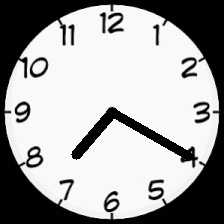

In [ ]:
PIL.Image.open(sample_image_path)

In [ ]:
batch_size = 32
img_size = 224

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
    )
val_datagen = ImageDataGenerator(
    rescale=1/255.
    )
test_datagen = ImageDataGenerator(
    rescale=1/255.
    )

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical'
    )

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
    )

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
    )

Found 11520 images belonging to 144 classes.
Found 1440 images belonging to 144 classes.
Found 1440 images belonging to 144 classes.


In [ ]:
img_size = 224
base_model = VGG16(
    include_top = False,
    weights = 'imagenet',
    input_shape = (img_size,img_size,3))

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(144, activation='softmax')(x)

model = Model(inputs=base_model.inputs, outputs=outputs)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# creating save folder
save_filepath = '/content/drive/MyDrive/TIP Files/CPE 028/Saved Model'
if os.path.exists(save_filepath) == False:
  os.makedirs(save_filepath)

In [ ]:
# checkpoint
model_path = os.path.join(save_filepath,'best_model.h5')
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# training model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
hist = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=callbacks_list
    )

Epoch 1/10
360/360 [==============================] - ETA: 0s - loss: 4.9765 - accuracy: 0.0056
Epoch 1: val_accuracy improved from -inf to 0.00903, saving model to /content/drive/MyDrive/TIP Files/CPE 028/Saved Model/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


360/360 [==============================] - 173s 468ms/step - loss: 4.9765 - accuracy: 0.0056 - val_loss: 4.9695 - val_accuracy: 0.0090
Epoch 2/10
360/360 [==============================] - ETA: 0s - loss: 4.8876 - accuracy: 0.0086
Epoch 2: val_accuracy improved from 0.00903 to 0.02292, saving model to /content/drive/MyDrive/TIP Files/CPE 028/Saved Model/best_model.h5
360/360 [==============================] - 170s 473ms/step - loss: 4.8876 - accuracy: 0.0086 - val_loss: 4.6657 - val_accuracy: 0.0229
Epoch 3/10
360/360 [==============================] - ETA: 0s - loss: 4.3067 - accuracy: 0.0437
Epoch 3: val_accuracy improved from 0.02292 to 0.20069, saving model to /content/drive/MyDrive/TIP Files/CPE 028/Saved Model/best_model.h5
360/360 [==============================] - 171s 474ms/step - loss: 4.3067 - accuracy: 0.0437 - val_loss: 3.0718 - val_accuracy: 0.2007
Epoch 4/10
360/360 [==============================] - ETA: 0s - loss: 2.7421 - accuracy: 0.2334
Epoch 4: val_accuracy improve

In [ ]:
# additional training model
add_hist = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=5,
    callbacks=callbacks_list
    )

Epoch 1/5
360/360 [==============================] - ETA: 0s - loss: 0.3619 - accuracy: 0.8761
Epoch 1: val_accuracy improved from 0.91528 to 0.92083, saving model to /content/drive/MyDrive/TIP Files/CPE 028/Saved Model/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


360/360 [==============================] - 169s 470ms/step - loss: 0.3619 - accuracy: 0.8761 - val_loss: 0.2239 - val_accuracy: 0.9208
Epoch 2/5
360/360 [==============================] - ETA: 0s - loss: 0.3044 - accuracy: 0.8940
Epoch 2: val_accuracy improved from 0.92083 to 0.95347, saving model to /content/drive/MyDrive/TIP Files/CPE 028/Saved Model/best_model.h5
360/360 [==============================] - 168s 467ms/step - loss: 0.3044 - accuracy: 0.8940 - val_loss: 0.1633 - val_accuracy: 0.9535
Epoch 3/5
360/360 [==============================] - ETA: 0s - loss: 0.2691 - accuracy: 0.9091
Epoch 3: val_accuracy improved from 0.95347 to 0.96042, saving model to /content/drive/MyDrive/TIP Files/CPE 028/Saved Model/best_model.h5
360/360 [==============================] - 172s 477ms/step - loss: 0.2691 - accuracy: 0.9091 - val_loss: 0.1363 - val_accuracy: 0.9604
Epoch 4/5
360/360 [==============================] - ETA: 0s - loss: 0.2243 - accuracy: 0.9255
Epoch 4: val_accuracy did not im